目标函数定义为:
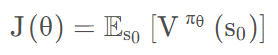

对该函数求导:
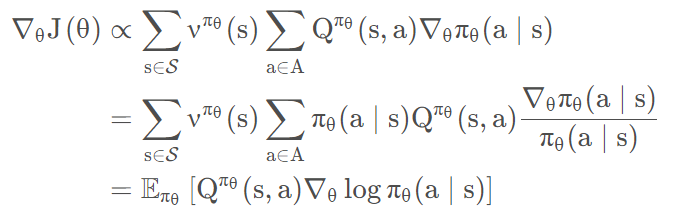

使用蒙特卡洛采样时,可得如下导函数:
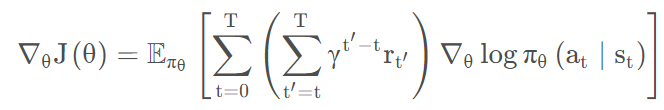

d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
d:\Conda\envs\RL_Simple\lib\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
d:\Conda\envs\RL_Simple\lib\site-packages\gym\core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. Th

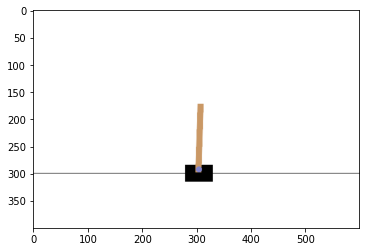

In [5]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('CartPole-v0')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [1]:
import torch

#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model(torch.randn(2, 4))

tensor([[0.3970, 0.6030],
        [0.3790, 0.6210]], grad_fn=<SoftmaxBackward0>)

In [2]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)

    #[1, 4] -> [1, 2]
    prob = model(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

0

In [6]:
#得到一局游戏的数据
def get_data():
    states = []
    rewards = []
    actions = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)

        #更新游戏状态,开始下一个动作
        state = next_state

    return states, rewards, actions


get_data()

([array([-0.02786947, -0.04983129,  0.0109636 , -0.02453802], dtype=float32),
  array([-0.0288661 ,  0.14513174,  0.01047284, -0.31374174], dtype=float32),
  array([-0.02596346, -0.05013783,  0.004198  , -0.01777451], dtype=float32),
  array([-0.02696622,  0.14492366,  0.00384251, -0.30912995], dtype=float32),
  array([-0.02406774, -0.05025283, -0.00234009, -0.01523769], dtype=float32),
  array([-0.0250728 , -0.24534114, -0.00264484,  0.27670598], dtype=float32),
  array([-0.02997962, -0.05018156,  0.00288928, -0.01680994], dtype=float32),
  array([-0.03098325,  0.14489885,  0.00255308, -0.30857986], dtype=float32),
  array([-0.02808528,  0.33998433, -0.00361852, -0.60045654], dtype=float32),
  array([-0.02128559,  0.14491318, -0.01562765, -0.3089156 ], dtype=float32),
  array([-0.01838733,  0.34025428, -0.02180596, -0.6064858 ], dtype=float32),
  array([-0.01158224,  0.5356742 , -0.03393567, -0.90595645], dtype=float32),
  array([-8.6875731e-04,  7.3123884e-01, -5.2054804e-02, -1.2091

In [7]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

17.0

In [8]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    #玩N局游戏,每局游戏训练一次
    for epoch in range(1000):
        #玩一局游戏,得到数据
        states, rewards, actions = get_data()

        optimizer.zero_grad()

        #反馈的和,初始化为0
        reward_sum = 0

        #从最后一步算起
        for i in reversed(range(len(states))):

            #反馈的和,从最后一步的反馈开始计算
            #每往前一步,>>和<<都衰减0.02,然后再加上当前步的反馈
            reward_sum *= 0.98
            reward_sum += rewards[i]

            #重新计算对应动作的概率
            state = torch.FloatTensor(states[i]).reshape(1, 4)
            #[1, 4] -> [1, 2]
            prob = model(state)
            #[1, 2] -> scala
            prob = prob[0, actions[i]]

            #根据求导公式,符号取反是因为这里是求loss,所以优化方向相反
            loss = -prob.log() * reward_sum

            #累积梯度
            loss.backward(retain_graph=True)

        optimizer.step()

        if epoch % 100 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(epoch, test_result)


train()

0 16.9
100 46.8
200 125.8
300 129.3
400 178.9
500 163.0
600 192.2
700 180.7
800 181.2
900 192.7


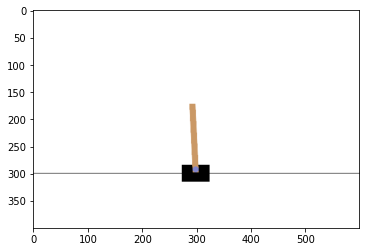

200.0

In [9]:
test(play=True)